<a href="https://colab.research.google.com/github/atjessehill/Thesis-Notebooks/blob/main/Music_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
from os import path
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from google.colab import drive
import json
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from sklearn import preprocessing
import statistics
from keras import backend as K
from keras import Model
import scipy
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
keras.backend.clear_session()

In [ ]:
BASE = 'drive/My Drive'
SONG_SAMPLE_PATH = 'Thesis/Samples'
DATA_SAVE_PATH = 'Thesis/InputData'

In [ ]:
""" 

Mostly unneeded code at this point, this was from earlier experiments using 
matrix of MFCC's, which needed to be rescaled.

"""

def load_npy(path, fold):
  x_train = np.load(os.path.join(path,'x_train_'+str(fold)+'.npy'))
  x_test = np.load(os.path.join(path,'x_test_'+str(fold)+'.npy'))
  y_train = np.load(os.path.join(path,'y_train_'+str(fold)+'.npy'))
  y_test = np.load(os.path.join(path,'y_test_'+str(fold)+'.npy'))
  x_train = x_train[..., np.newaxis]
  x_test = x_test[..., np.newaxis]
  return x_train, x_test, y_train, y_test
  # imgs_validate = np.load('imgs_validate.npy')

def rescale_data():
  scaler = preprocessing.MinMaxScaler()
  mfcc = []
  i = 0
  for i, (d) in enumerate(data['mfcc']):
    scaler.fit(d)
    transform = scaler.transform(d)
    mfcc.append(transform)
  x = np.array(mfcc)
  y = np.array(data['labels'])

  return x, y

def load_auto(path):
  with open(os.path.join(BASE, DATA_SAVE_PATH, path), 'r') as fp:
    data = json.load(fp)
  x = np.empty(shape=(len(data['mfcc']), 18))
  y = np.empty(shape=(len(data['labels']), 1))
  for i in data['mfcc']:
    np.append(x, np.array(i))

  for i in data['lables']:
    np.append(y, )

  x = np.array()
  y = np.array()


# path to images dataset. Recommended to write down entire path to avoid errors (i.e "C:/User/Desktop.../raw/)
def load_data(path):
  with open(os.path.join(BASE, DATA_SAVE_PATH, path), 'r') as fp:
    data = json.load(fp)

  x = np.array(data['mfcc'])
  y = np.array(data['labels'])
  return x, y

def load_splits():
  with open(os.path.join(BASE, DATA_SAVE_PATH, '10-fold-splits.json'), 'r') as fp:
    data = json.load(fp)

  return data


def prepare_datasets(path, test_size, validation_size=None, cnn=False):

  data = {}
  X, y = load_npy(path)
  # create train/test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

  if validation_size:
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

  if cnn:
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    if validation_size:
      X_validation = X_validation[..., np.newaxis]

  data['X_train'] = X_train
  data['X_test'] = X_test
  data['y_train'] = y_train
  data['y_test'] = y_test

  if validation_size:
    data['X_validation'] = X_validation
    data['y_validation'] = y_validation

  return data

In [ ]:
def build_cnn(input_shape):

  model = keras.Sequential()

  #1st conv layer
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # #2nd conv layer
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # #3rd conv layer
  model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # # flatten the output and feed it into the dense layer
  model.add(keras.layers.Flatten()) # converts 2D data into 1D
  # TODO 1024 add one more dense layer. Smoothly reduce # of neurons
  # Include new features here

  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.3))

  # # output layer
  model.add(keras.layers.Dense(2, activation='softmax'))

  return model

def build_cnn_v2(input_shape):

  model = keras.Sequential()

  #1st conv layer
  # TODO adjust using horizontal filter for temporal features
  model.add(keras.layers.Conv2D(32, (2, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((4, 1), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # #2nd conv layer
  # TODO adjust using vertical filter for timbral features
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # #3rd conv layer
  # TODO add 4th convolutional layer 
  model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # # flatten the output and feed it into the dense layer
  model.add(keras.layers.Flatten()) # converts 2D data into 1D
  # TODO 1024 add one more dense layer. Smoothly reduce # of neurons
  # Include new features here
  model.add(keras.layers.Dense(1024, activation='relu'))
  # model.add(keras.layers.Dense(512, activation='relu'))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.3))

  # # output layer
  model.add(keras.layers.Dense(2, activation='softmax'))

  return model

def build_cnn_v3(input_shape):

  # Adapted from Keunwoo Choi 
  model = keras.Sequential()

  #1st conv layer
  # TODO adjust using horizontal filter for temporal features
  model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((2, 4), padding='same'))
  model.add(keras.layers.Dropout(0.5))

  model.add(keras.layers.BatchNormalization())

  # #2nd conv layer
  # #TODO adjust using vertical filter for timbral features
  model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((2, 4), padding='same'))
  model.add(keras.layers.Dropout(0.5))

  model.add(keras.layers.BatchNormalization())

  model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((2, 4), padding='same'))
  model.add(keras.layers.Dropout(0.5))

  model.add(keras.layers.BatchNormalization())

  model.add(keras.layers.Conv2D(1024, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((3, 5), padding='same'))
  model.add(keras.layers.Dropout(0.5))

  model.add(keras.layers.BatchNormalization())

  model.add(keras.layers.Conv2D(2048, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((4, 8), padding='same'))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.BatchNormalization())

  model.add(keras.layers.Conv2D(1024, (1, 1), activation='relu', padding='same', input_shape=input_shape))
  # # # #3rd conv layer
  # # # TODO add 4th convolutional layer 
  # model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  # model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  # model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  # model.add(keras.layers.MaxPool2D((2, 2), padding='same'))
  # model.add(keras.layers.BatchNormalization())

  # # flatten the output and feed it into the dense layer
  # model.add(keras.layers.Flatten()) # converts 2D data into 1D
  # TODO 1024 add one more dense layer. Smoothly reduce # of neurons
  # Include new features here
  # model.add(keras.layers.Dense(1024, activation='relu'))
  # model.add(keras.layers.Dense(512, activation='relu'))
  # model.add(keras.layers.Dense(64, activation='relu'))
  # model.add(keras.layers.Dropout(0.3))

  # # output layer
  model.add(keras.layers.Dense(2, activation='sigmoid'))

  return model

def build_cnn_v4(input_shape):
  # End-to-end learning Sander Dieleman, Benjamin Schrauwen
  model = keras.Sequential()

  #1st conv layer
  # TODO adjust using horizontal filter for temporal features
  model.add(keras.layers.Conv2D(32, (1, 8), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((1, 4), padding='same'))

  model.add(keras.layers.Conv2D(32, (1, 8), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((1, 4), padding='same'))

  # # flatten the output and feed it into the dense layer
  model.add(keras.layers.Flatten()) # converts 2D data into 1D
  # TODO 1024 add one more dense layer. Smoothly reduce # of neurons
  # Include new features here
  model.add(keras.layers.Dense(100, activation='relu'))
  # model.add(keras.layers.Dense(512, activation='relu'))
  model.add(keras.layers.Dense(50, activation='relu'))
  model.add(keras.layers.Dropout(0.3))

  # # output layer
  model.add(keras.layers.Dense(2, activation='sigmoid'))

  return model

def build_cnn_v5(input_shape):

  # Adapted from Jordi Pons

  inputs = keras.Input(shape=input_shape)
  print(inputs.shape)

  # Block One
  one_x_100 = keras.layers.Conv2D(10, (100, 1), activation='elu')(inputs)
  mp_one_x_100 = keras.layers.MaxPool2D((one_x_100.shape[1], 4))(one_x_100)
  # mp_one_x_100 = keras.layers.ZeroPadding2D(padding=((1, 0), (0, 0)))(mp_one_x_100)

  three_x_100 = keras.layers.Conv2D(6, (100, 3), strides=(1, 1), activation='elu')(inputs)
  # three_x_100 = keras.layers.ZeroPadding2D(padding=1)(three_x_100)
  mp_three_x_100 = keras.layers.MaxPool2D((three_x_100.shape[1],4), padding='same')(three_x_100)
  # mp_three_x_100 = keras.layers.ZeroPadding2D(padding=((1, 0), (0, 0)))(mp_three_x_100)

  five_x_100 = keras.layers.ZeroPadding2D(padding=2)(inputs)
  five_x_100 = keras.layers.Conv2D(3, (100, 5), strides=(1, 1), activation='elu')(five_x_100)
  mp_five_x_100 = keras.layers.MaxPool2D((five_x_100.shape[1], 4), padding='same')(five_x_100)

  seven_x_100 = keras.layers.ZeroPadding2D(padding=3)(inputs)
  seven_x_100 = keras.layers.Conv2D(3, (100, 7), strides=(1, 1), activation='elu')(seven_x_100)
  mp_seven_x_100 = keras.layers.MaxPool2D((seven_x_100.shape[1], 4), padding='same')(seven_x_100)


  # Block Two
  one_x_75 = keras.layers.Conv2D(15, (100, 1), activation='elu')(inputs)
  mp_one_x_75 = keras.layers.MaxPool2D((one_x_75.shape[1], 4), padding='same')(one_x_75)
  # mp_one_x_75 = keras.layers.ZeroPadding2D(padding=((1, 0), (0, 0)))(mp_one_x_75)

  three_x_75 = keras.layers.Conv2D(10, (100, 3), strides=(1, 1), activation='elu')(inputs)
  # three_x_75 = keras.layers.ZeroPadding2D(padding=1)(three_x_75)
  mp_three_x_75 = keras.layers.MaxPool2D((three_x_75.shape[1], 4), padding='same')(three_x_75)
  # mp_three_x_75 = keras.layers.ZeroPadding2D(padding=((1, 0), (0, 0)))(mp_three_x_75)

  five_x_75 = keras.layers.ZeroPadding2D(padding=2)(inputs)
  five_x_75 = keras.layers.Conv2D(5, (100, 5), strides=(1, 1), activation='elu')(five_x_75)
  mp_five_x_75 = keras.layers.MaxPool2D((five_x_75.shape[1], 4), padding='same')(five_x_75)

  seven_x_75 = keras.layers.ZeroPadding2D(padding=3)(inputs)
  seven_x_75 = keras.layers.Conv2D(5, (100, 7), strides=(1, 1), activation='elu')(seven_x_75)
  mp_seven_x_75 = keras.layers.MaxPool2D((seven_x_75.shape[1], 4), padding='same')(seven_x_75)

  # Block 3
  one_x_25 = keras.layers.Conv2D(15, (100, 1), activation='elu')(inputs)
  mp_one_x_25 = keras.layers.MaxPool2D((one_x_25.shape[1], 4), padding='same')(one_x_25)
  # mp_one_x_25 = keras.layers.ZeroPadding2D(padding=((1, 0), (0, 0)))(mp_one_x_25)

  three_x_25 = keras.layers.ZeroPadding2D(padding=1)(inputs)
  three_x_25 = keras.layers.Conv2D(10, (100, 3), strides=(1, 1), activation='elu')(three_x_25)
  mp_three_x_25 = keras.layers.MaxPool2D((three_x_25.shape[1], 4), padding='same')(three_x_25)
  # mp_three_x_25 = keras.layers.ZeroPadding2D(padding=((1, 0), (0, 0)))(mp_three_x_25)

  five_x_25 = keras.layers.Conv2D(5, (100, 5), strides=(1, 1), activation='elu')(inputs)
  five_x_25 = keras.layers.ZeroPadding2D(padding=2)(five_x_25)
  mp_five_x_25 = keras.layers.MaxPool2D((five_x_25.shape[1], 4), padding='same')(five_x_25)

  seven_x_25 = keras.layers.Conv2D(5, (100, 7), strides=(1, 1), activation='elu')(inputs)
  seven_x_25 = keras.layers.ZeroPadding2D(padding=3)(seven_x_25)
  mp_seven_x_25 = keras.layers.MaxPool2D((seven_x_25.shape[1], 4), padding='same')(seven_x_25)

  # print("Block 1")
  # print(mp_one_x_100.shape)
  # print(mp_three_x_100.shape)
  # print(mp_five_x_100.shape)
  # print(mp_seven_x_100.shape)

  # print("Block 2")
  # print(mp_one_x_75.shape)
  # print(mp_three_x_75.shape)
  # print(mp_five_x_75.shape)
  # print(mp_seven_x_75.shape)

  # print("Block 3")
  # print(mp_one_x_25.shape)
  # print(mp_three_x_25.shape)
  # print(mp_five_x_25.shape)
  # print(mp_seven_x_25.shape)

  music_filters = keras.layers.Concatenate(axis=-1)([mp_one_x_100, mp_three_x_100, mp_five_x_100, mp_seven_x_100,
                                                     mp_one_x_75, mp_three_x_75, mp_five_x_75, mp_seven_x_75,
                                                     mp_one_x_25, mp_three_x_25, mp_five_x_25, mp_seven_x_25])
  print(music_filters.shape)  # (None, 1, 323, 92)
  reshape = keras.layers.Reshape((music_filters.shape[3], music_filters.shape[2], music_filters.shape[1]))(music_filters)

  print('\n Reshape')
  print(reshape.shape) # (None, 92, 323, 1)

  layer_4 = keras.layers.Conv2D(32, (reshape.shape[1], 8), activation='elu')(reshape)
  
  print('\n Four')
  print(layer_4.shape)

  five_pre = keras.layers.MaxPool2D((1, 4), padding='same')(layer_4)
  five = keras.layers.Reshape((five_pre.shape[3], five_pre.shape[2], five_pre.shape[1]))(five_pre)

  print('\n Five')
  print(five_pre.shape)
  print(five.shape)

  # Dense Layers
  flat = keras.layers.Flatten()(five)
  dropout1 = keras.layers.Dropout(0.5)(flat)
  six = keras.layers.Dense(100, activation='relu')(dropout1)
  dropout2 = keras.layers.Dropout(0.5)(six)
  seven = keras.layers.Dense(2, activation='sigmoid')(dropout2)
  model = Model(inputs, [seven])

  return model

def build_lstm(input_shape):

  model = keras.Sequential()

  model.add(keras.layers.LSTM(256, input_shape=input_shape, return_sequences=True))
  model.add(keras.layers.LSTM(256))

  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(256, activation='relu'))

  model.add(keras.layers.Dropout(0.30))

  model.add(keras.layers.Dense(2, activation='softmax'))

  return model

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2, figsize=(5, 5))

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="val accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="upper left")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="val error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper left")
    axs[1].set_title("Error eval")
    # plt.figure(figsize=(30,30))
    plt.show()

In [ ]:
def run_cnn(X_train, X_test, y_train, y_test):
  print(X_train.shape[1])
  print(X_train.shape[2])
  print(X_train.shape[3])

  input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
  model = build_cnn_v5(input_shape)
  optimizer = keras.optimizers.Adam(learning_rate=1e-5)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
  weights = os.path.join(BASE, 'Thesis', 'weights.h5')
  callbacks = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, min_delta=0, mode='max'), keras.callbacks.ModelCheckpoint(weights, monitor='val_accuracy', mode='max', save_best_only=True)]

  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=300, callbacks=callbacks)
  m = max(history.history['val_accuracy'])
  plot_history(history)
  model.load_weights(weights)
  return model, m

def run_lstm(X_train, X_test, y_train, y_test):
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=30)
    plot_history(history)

In [ ]:
model = build_cnn_v5((128, 1292, 1))

(None, 128, 1292, 1)
(None, 1, 323, 92)

 Reshape
(None, 92, 323, 1)

 Four
(None, 1, 316, 32)

 Five
(None, 1, 79, 32)
(None, 32, 79, 1)


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 1292, 1 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 132, 1296, 1) 0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 1298, 1) 0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 132, 1296, 1) 0           input_1[0][0]                    
_______________________________________________________________________________________

Starting 2
128
1292
1
(None, 128, 1292, 1)
(None, 1, 323, 92)

 Reshape
(None, 92, 323, 1)

 Four
(None, 1, 316, 32)

 Five
(None, 1, 79, 32)
(None, 32, 79, 1)
Epoch 1/300
143/143 [==============================] - 9s 60ms/step - loss: 0.6913 - accuracy: 0.5295 - val_loss: 0.6991 - val_accuracy: 0.4494
Epoch 2/300
143/143 [==============================] - 8s 54ms/step - loss: 0.6890 - accuracy: 0.5650 - val_loss: 0.7012 - val_accuracy: 0.4494
Epoch 3/300
143/143 [==============================] - 8s 54ms/step - loss: 0.6870 - accuracy: 0.5637 - val_loss: 0.7035 - val_accuracy: 0.4494
Epoch 4/300
143/143 [==============================] - 8s 54ms/step - loss: 0.6861 - accuracy: 0.5606 - val_loss: 0.7048 - val_accuracy: 0.4494
Epoch 5/300
143/143 [==============================] - 8s 54ms/step - loss: 0.6867 - accuracy: 0.5571 - val_loss: 0.7039 - val_accuracy: 0.4494
Epoch 6/300
143/143 [==============================] - 8s 54ms/step - loss: 0.6881 - accuracy: 0.5536 - val_loss: 0.7043

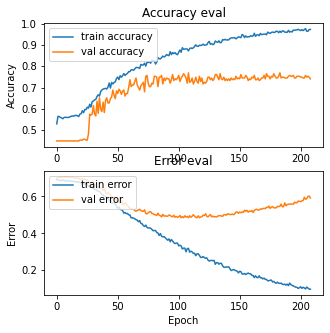

[[1.89380292e-02 2.66220421e-02]
 [9.33439359e-02 2.92497245e-03]
 [8.42635706e-02 1.54422410e-03]
 [6.88970834e-02 2.78981612e-03]
 [6.66370168e-02 2.33437959e-03]
 [1.04806885e-01 2.44096364e-03]
 [7.89373219e-02 2.10208120e-03]
 [9.00132284e-02 2.27260427e-03]
 [2.50202399e-02 5.41830203e-03]
 [3.83084714e-02 7.41844717e-03]
 [3.16670425e-02 3.73918936e-03]
 [7.53960162e-02 2.94234836e-03]
 [3.42641212e-02 2.87251570e-03]
 [4.06012088e-02 4.90869349e-03]
 [5.04006930e-02 3.06443055e-03]
 [7.99212456e-02 3.70004238e-03]
 [4.64081429e-02 1.42826478e-03]
 [1.06156468e-01 9.00302455e-03]
 [1.09848134e-01 1.12575684e-02]
 [2.03483403e-01 1.54780429e-02]
 [9.81301889e-02 1.45785362e-02]
 [9.45720226e-02 1.65661760e-02]
 [8.45316797e-02 1.46987429e-02]
 [1.34383053e-01 7.06416601e-03]
 [4.94938008e-02 1.26794055e-02]
 [3.98557168e-03 5.13775134e-03]
 [1.41985454e-02 5.13650570e-03]
 [2.37745065e-02 2.64991191e-03]
 [1.05711907e-01 7.13879941e-03]
 [7.83469081e-02 1.45253716e-02]
 [1.026153

In [ ]:
splits = load_splits()
maxes = []
ensembleMax = []
for fold in range(3, 10):

  testSamples = splits[fold]['test']
  trainLength = 0
  testLength = 0
  ytrain = []
  ytest = []
  songSections = []
  songClassification = []


  # Calculates the size of train and test folds
  for i, (file) in enumerate(splits[fold]['train']):
    dir = os.path.join(BASE, DATA_SAVE_PATH, 'Spectrograms_30sec', file.replace(".mp3", "*"))
    clipSections = len(glob.glob(dir))
    trainLength+= clipSections
    if os.path.exists(os.path.join(BASE, 'Thesis', 'Samples', 'FULL_TRACKS', 'noDJ', file)):
      ytrain_ = [0]*clipSections
    elif os.path.exists(os.path.join(BASE, 'Thesis', 'Samples', 'FULL_TRACKS', 'yesDJ', file)):
      ytrain_ = [1]*clipSections
    else:
      print("Could not find file", file)
    ytrain = ytrain+ytrain_
  
  for i, (file) in enumerate(splits[fold]['test']):
    dir = os.path.join(BASE, DATA_SAVE_PATH, 'Spectrograms_30sec', file.replace(".mp3", "*"))
    clipSections = len(glob.glob(dir))
    testLength+= clipSections
    songSections.append(clipSections)
    if os.path.exists(os.path.join(BASE, 'Thesis', 'Samples', 'FULL_TRACKS', 'noDJ', file)):
      ytest_ = [0]*clipSections
      songClassification.append(0)
    elif os.path.exists(os.path.join(BASE, 'Thesis', 'Samples', 'FULL_TRACKS', 'yesDJ', file)):
      ytest_ = [1]*clipSections
      songClassification.append(1)
    else:
      print("Could not find file", file)

    ytest = ytest+ytest_
  
  # Create test/train data arrays

  x_train = np.ndarray((trainLength, 128, 1292), dtype=np.uint8)
  x_test = np.ndarray((testLength, 128, 1292), dtype=np.uint8)
  y_train = np.array(ytrain)
  y_test = np.array(ytest)

  # Load test/train data
  loc = 0
  for url in splits[fold]['train']:
    url = url.replace('.mp3', '')
    for loadpath in glob.glob(os.path.join(BASE, DATA_SAVE_PATH, 'Spectrograms_30sec', url+'*.npy')):
      x_train[loc] = np.load(loadpath)
      loc+=1
  x_train = x_train.astype('float32')
  x_train = x_train.astype('float32')
  mean = np.mean(x_train)
  std = np.mean(x_train)
  x_train -= mean
  x_train /= std
  x_train = x_train[..., np.newaxis]

  loc = 0
  for url in splits[fold]['test']:
    url = url.replace('.mp3', '')
    for loadpath in glob.glob(os.path.join(BASE, DATA_SAVE_PATH, 'Spectrograms_30sec', url+'*.npy')):
      x_test[loc] = np.load(loadpath)
      loc+=1
  x_test = x_test.astype('float32')
  x_test = x_test.astype('float32')
  mean = np.mean(x_test)
  std = np.mean(x_test)
  x_test -= mean
  x_test /= std
  x_test = x_test[..., np.newaxis]

  print(f"Starting {fold}")
  model, m = run_cnn(x_train, x_test, y_train, y_test)

  # Ensemble voting
  start = 0
  print(model.predict(x_test))
  predictions = []
  # sig_predictions = model.predict(x_test)
  # for i in sig_predictions:
  #   predictions.append(np.argmax(i[0][0]))
  predictions = np.argmax(model.predict(x_test), axis=1)

  ensemblePrediction = []
  for song in range(0, len(songClassification)):
    correct = 0
    incorrect = 0
    # print(splits[fold]['test'][song])
    print(y_test[start:start+songSections[song]])
    print(predictions[start:start+songSections[song]])
    for i, j in zip(y_test[start:start+songSections[song]], predictions[start:start+songSections[song]]):
      if i==j==songClassification[song]:
        correct+=1
    # print(f"{correct} {songSections[song]}")
    start=start+songSections[song]
    ensemblePrediction.append(correct/songSections[song])


  correctPreds = 0
  incorrectPreds = 0
  for i in ensemblePrediction:
    if i >= .50:
      correctPreds+=1
    else:
      incorrectPreds+=1
    
  maxes.append(m)
  ensembleMax.append(correctPreds/(correctPreds+incorrectPreds))
  
  print(f"Correct Predictions: {correctPreds}, incorrect predictions: {incorrectPreds}")

  # maxes.append(m)
# avg = sum(maxes)/len(maxes)
# std = statistics.stdev(maxes)
# print(f"AVG: {avg} STD: {std} ")


In [ ]:
sum(maxes)/len(maxes), sum(ensemblePrediction)/len(ensemblePrediction)

(0.6784383356571198, 0.6359838654546981)

In [ ]:
statistics.stdev(maxes)

0.06359719809292419

In [ ]:
statistics.stdev(ensemblePrediction)

0.3913295301539358

In [ ]:
  # print(model.predict(x_test))
  # predictions = np.argmax(model.predict(x_test))
  predictions = model.predict(x_test)

In [ ]:
for i in predictions:
  print(np.argmax(i[0][0]))
  break

1


In [ ]:
ensembleMax

[1.5,
 3.75,
 8.5,
 2.1666666666666665,
 2.1666666666666665,
 3.75,
 3.75,
 2.8,
 1.375,
 2.1666666666666665]

In [ ]:
ensemblePrediction

[0.8666666666666667,
 0.0,
 0.7333333333333333,
 0.875,
 0.1111111111111111,
 0.9285714285714286,
 1.0,
 0.8571428571428571,
 0.15384615384615385,
 0.8571428571428571,
 0.9375,
 0.0,
 0.0,
 1.0,
 0.3684210526315789,
 0.8235294117647058,
 0.5714285714285714,
 1.0,
 1.0]